In [44]:
print(ord("A") % 5 + 1)

3


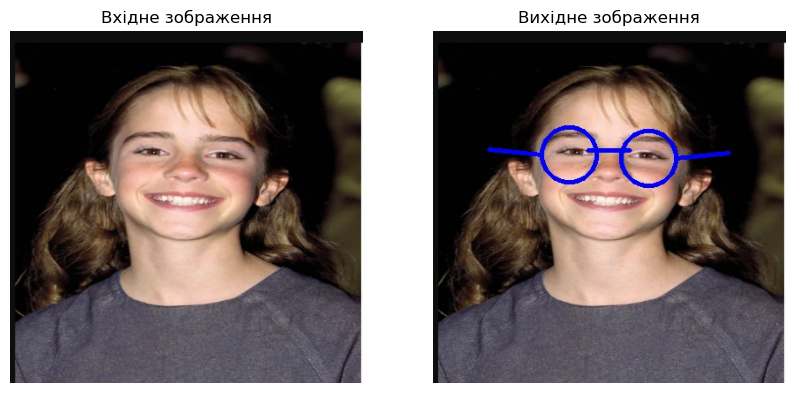

In [4]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt


color_dict = {
    'red': (0, 0, 255),
    'blue': (255, 0, 0),
    'cian': (255, 255, 0),  
    'magenta': (255, 0, 255),
    'yellow': (0, 255, 255),
}


df = pd.read_excel('lab6.xlsx')


index = 0
data_row = df.iloc[index]


input_image_name = data_row['file name']


line_width = int(data_row['line width'])


temple_length = 60 


if 'image size' in data_row and not pd.isna(data_row['image size']):
    
    size_str = str(data_row['image size'])
    width_str, height_str = size_str.lower().split('x')
    width, height = int(width_str), int(height_str)
else:
    width, height = None, None  


if 'glasses color' in data_row and not pd.isna(data_row['glasses color']):
    color_name = data_row['glasses color'].lower()
    glasses_color = color_dict.get(color_name)
    if glasses_color is None:
        
        glasses_color = color_dict['yellow']  
else:
    glasses_color = color_dict['yellow']  


def add_glasses_to_face(image_path, output_path, line_width, temple_length=60, resize_dims=None, glasses_color=(0, 255, 255)):

    image = cv2.imread(image_path)
    if image is None:
        print(f"Ошибка: Изображение '{image_path}' не найдено.")
        return

    
    if resize_dims is not None:
        image = cv2.resize(image, resize_dims)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    
   
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
   

    if len(faces) == 0:
        
        cv2.imwrite(output_path, image)  
        return

    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = image[y:y+h, x:x+w]
        
       
        eyes = eye_cascade.detectMultiScale(roi_gray, scaleFactor=1.1, minNeighbors=3, minSize=(10, 10))
       

        if len(eyes) < 2:
            
            
            eyes = eye_cascade.detectMultiScale(roi_gray, scaleFactor=1.05, minNeighbors=3, minSize=(5, 5))
            
            if len(eyes) < 2:
                continue  

       
        eyes = sorted(eyes, key=lambda ex: ex[2]*ex[3], reverse=True)[:2]

        if len(eyes) < 2:
            continue
        
        eyes = sorted(eyes, key=lambda ex: ex[0])

        (ex1, ey1, ew1, eh1), (ex2, ey2, ew2, eh2) = eyes[:2]

        eye1_center = (x + ex1 + ew1 // 2, y + ey1 + eh1 // 2)
        eye2_center = (x + ex2 + ew2 // 2, y + ey2 + eh2 // 2)
        
        radius = int(0.5 * (ew1 + ew2) / 2)

        eye1_center = (eye1_center[0] - int(0.1 * radius), eye1_center[1])
        eye2_center = (eye2_center[0] + int(0.1 * radius), eye2_center[1])

        cv2.circle(image, eye1_center, radius, glasses_color, line_width)
        cv2.circle(image, eye2_center, radius, glasses_color, line_width)
        
        bridge_y = int((eye1_center[1] + eye2_center[1]) / 2 - 0.2 * radius)
        cv2.line(image, (eye1_center[0] + int(0.7 * radius), bridge_y), (eye2_center[0] - int(0.7 * radius), bridge_y), glasses_color, line_width)
        
        cv2.line(image, (eye1_center[0] - radius, eye1_center[1]),
                 (eye1_center[0] - radius - temple_length, eye1_center[1] - int(0.2 * radius)), glasses_color, line_width)
        cv2.line(image, (eye2_center[0] + radius, eye2_center[1]),
                 (eye2_center[0] + radius + temple_length, eye2_center[1] - int(0.2 * radius)), glasses_color, line_width)
        break  

    cv2.imwrite(output_path, image)
    
input_image_path = 'Images/' + input_image_name
output_image_path = 'output_' + input_image_name

resize_dims = (width, height) if width and height else None

add_glasses_to_face(input_image_path, output_image_path, line_width, temple_length, resize_dims, glasses_color)

input_image = cv2.imread(input_image_path)

if input_image is None:
    print(f"Ошибка: Входное изображение '{input_image_path}' не найдено.")
else:
    if resize_dims is not None:
        input_image = cv2.resize(input_image, resize_dims)

    output_image = cv2.imread(output_image_path)

    input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(input_image_rgb)
    plt.title("Вхідне зображення")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(output_image_rgb)
    plt.title("Вихідне зображення")
    plt.axis("off")

    plt.show()
